In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [2]:
df = pd.read_csv("data/fake_news.csv", parse_dates=["timestamp"])

from sklearn.model_selection import train_test_split

df["label"] = (df["label"] == "fake").astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    df[["timestamp", "baseurl", "content"]], df["label"],
    test_size=0.25, random_state=42,
)

In [3]:
def make_word_features(df, words):
    features = {word: df["content"].str.contains(word) for word in words}
    return pd.DataFrame(features)

In [4]:
word_features = [
    # names of presidential candidates
    'trump', 'clinton',
    # congress words
    'state', 'vote', 'congress', 'shutdown',
    
    # other possibly useful words
    'military', 'princ', 'investig', 'antifa', 
    'joke', 'homeless', 'swamp', 'fbi', 'cnn',
]

(sec:fake_news_modeling)=
# Modeling

Now that we've obtained, cleaned, and explored our data, let's fit models to predict whether articles are real or fake. In this section, we use logistic regression because we have a binary classification problem. We fit three different models that increase in complexity. First, we fit a model that just uses the presence of a single handpicked word in the document as an explanatory feature. Then we fit a model that uses multiple handpicked words. Finally, we fit a model that uses all the words in the train set, vectorized using the tf-idf transform (introduced in {numref}`Chapter %s <ch:text>`). Let's start with the simple single-word model.

## A Single-Word Model

Our EDA showed that the word _vote_ is related to whether an article is labeled `real` or `fake`. To test this, we fit a logistic regression model using a single binary feature: `1` if the word _vote_ appears in the article and `0` if not. We start by defining a function to lowercase the article content: 

In [5]:
def lowercase(df):
    return df.assign(content=df['content'].str.lower())

For our first classifier, we only use the word _vote_:

In [6]:
one_word = ['vote']

We can chain the `lowercase` function and the function `make_word_features` from our EDA into a `scikit-learn` pipeline. This provides a convenient way to transform and fit data all at once:

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import FunctionTransformer

In [8]:
model1 = make_pipeline(
    FunctionTransformer(lowercase),
    FunctionTransformer(make_word_features, kw_args={'words': one_word}),
    LogisticRegressionCV(Cs=10, solver='saga', n_jobs=4, max_iter=10000),
)

When used, the preceding pipeline converts the characters in the article content to lowercase, creates a dataframe with a binary feature for each word of interest, and fits a logistic regression model on the data using $ L_2 $ regularization. Additionally, the `LogisticRegressionCV` function uses cross-validation (5-fold by default) to select the best regularization parameter. (See {numref}`Chapter %s <ch:risk>` for more on regularization and cross-validation.)

Let's use the pipeline to fit the training data:

In [9]:
%%time

model1.fit(X_train, y_train)
print(f'{model1.score(X_train, y_train):.1%} accuracy on training set.')

64.9% accuracy on training set.
CPU times: user 110 ms, sys: 42.7 ms, total: 152 ms
Wall time: 144 ms


Overall, the single-word classifier only classifies 65% of articles correctly. We plot the confusion matrix of the classifier on the train set to see what kinds of mistakes it makes:

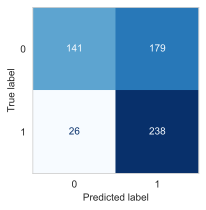

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    model1, X_train, y_train, cmap=plt.cm.Blues, colorbar=False
)
plt.grid(False);

Our model often misclassifies real articles (0) as fake (1). Since this model is simple, we can take a look at the probabilities for the two cases: the word _vote_ is in the article or is not:

In [11]:
vote_present = pd.DataFrame({'vote': [1]})
vote_absent = pd.DataFrame({'vote': [0]})

log_reg = model1.named_steps['logisticregressioncv']
print(f'"vote" present: {log_reg.predict_proba(vote_present)}')
print(f'"vote" absent: {log_reg.predict_proba(vote_absent)}')

"vote" present: [[0.72 0.28]]
"vote" absent: [[0.48 0.52]]


When an article contains the word _vote_, the model gives a high probability to the article being real, and when _vote_ is absent, the probability leans slightly toward the article being fake. We encourage readers to verify this for themselves using the definition of the logistic regression model and the fitted coefficients:

In [12]:
print(f'Intercept: {log_reg.intercept_[0]:.2f}')
[[coef]] = log_reg.coef_
print(f'"vote" Coefficient: {coef:.2f}')

Intercept: 0.08
"vote" Coefficient: -1.00


As we saw in {numref}`Chapter %s <ch:logistic>`, the coefficient indicates the size of the change in the odds with a change in the explanatory variable. With a 0-1 variable like the presence or absence of a word in an article, this has a particularly intuitive meaning. For an article with _vote_ in it, the odds of being fake decrease by a factor of $\exp(\theta_{vote})$, which is:

In [13]:
np.exp(coef) 

0.36836305405149367

:::{note}

Remember that in this modeling scenario, a label of `0`  corresponds to a
real article and a label of `1` corresponds to a fake article. This might
seem a bit counterintuitive---we're saying that a "true positive" is when
a model correctly predicts a fake article as fake. In binary classification, we
typically say a "positive" result is the one with the presence of something
unusual. For example, a person who tests positive for an illness would expect
to have the illness. 

:::

Let's make our model a bit more sophisticated by introducing additional word features.

## Multiple-Word Model

We create a model that uses all of the words we examined in our EDA of the train set, except for _the_. Let's fit a model using these 15 features:

In [14]:
model2 = make_pipeline(
    FunctionTransformer(lowercase),
    FunctionTransformer(make_word_features, kw_args={'words': word_features}),
    LogisticRegressionCV(Cs=10, solver='saga', n_jobs=4, max_iter=10000),
)

In [15]:
%%time

model2.fit(X_train, y_train)
print(f'{model2.score(X_train, y_train):.1%} accuracy on training set.')

74.8% accuracy on training set.
CPU times: user 1.54 s, sys: 59.1 ms, total: 1.6 s
Wall time: 637 ms


This model is about 10 percentage points more accurate than the one-word model. It may seem a bit surprising that going from a one-word model to a 15-word model only gains 10 percentage points. The confusion matrix is helpful in teasing out the kinds of errors made:

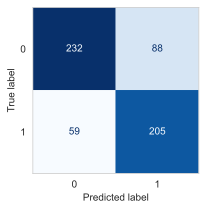

In [16]:
ConfusionMatrixDisplay.from_estimator(
    model2, X_train, y_train, cmap=plt.cm.Blues, colorbar=False
)
plt.grid(False);

We can see that this classifier does a better job classifying real articles accurately. However, it makes more mistakes than the simple one-word model when classifying fake article—59 of the fake articles were classified as real. In this scenario, we might be more concerned about misclassifying an article as fake when it is real. So we wish to have a high precision—the ratio of fake articles correctly predicted as fake to articles predicted as fake:

In [17]:
model1_precision = 238 / (238 + 179)
model2_precision = 205 / (205 + 88)

[round(num, 2) for num in [model1_precision, model2_precision]]

[0.57, 0.7]

The precision in our larger model is improved, but about 30% of the articles labeled as fake are actually real. Let's take a look at the model's coefficients:

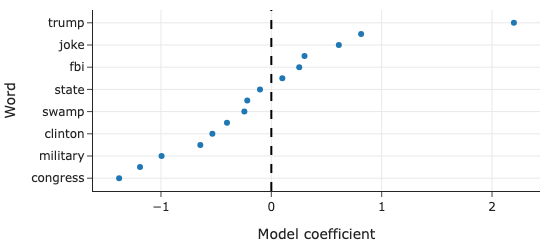

In [18]:
log_reg2 = model2.named_steps['logisticregressioncv']
coefs = (pd.DataFrame({'word': word_features, 'coef': log_reg2.coef_[0]})
         .sort_values('coef')
        )
fig = px.scatter(coefs, x='coef', y='word',
                 labels={'coef': 'Model coefficient','word':'Word'},
                 width=350, height=250)
fig.add_vline(x=0, line_width=2, line_dash="dash", opacity=1)
fig

We can make a quick interpretation of the coefficients by looking at their signs. The large positive values on _trump_ and _investig_ indicate that the model predicts that new articles containing these words have a higher probability of being fake. The reverse is true for words like _congress_ and _vote_, which have negative weights. We can use these coefficients to compare the log odds when an article does or does not contain a particular word. 

Although this larger model performs better than the simple one-word model, we had to handpick the word features using our knowledge of the news. What if we missed the words that are highly predictive? To address this, we can incorporate all the words in the articles using the tf-idf transform.

## Predicting with the tf-idf Transform

For the third and final model, we use the term frequency-inverse document frequency (tf-idf) transform from {numref}`Chapter %s <ch:text>` to vectorize the entire text of all articles in the train set. Recall that with this transform, an article is converted into a vector with one element for each word that appears in any of the 564 articles. The vector consists of normalized counts of the number of times the word appears in the article normalized by the rareness of the word. The tf-idf puts more weight on words that only appear in a few documents. This means that our classifier uses all the words in the train set's news articles for prediction. As we've done when we introduced tf-idf, first we remove stopwords, then we tokenize the words, and then we use the `TfidfVectorizer` from `scikit-learn`:

In [19]:
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = set(nltk.corpus.stopwords.words('english'))
porter_stemmer = PorterStemmer()

def stemming_tokenizer(document):
    return [porter_stemmer.stem(word)
            for word in nltk.word_tokenize(document)
            if word not in stop_words]
    return words

In [20]:
tfidf = TfidfVectorizer(tokenizer=stemming_tokenizer, token_pattern=None)

In [21]:
from sklearn.compose import make_column_transformer

model3 = make_pipeline(
    FunctionTransformer(lowercase),
    make_column_transformer((tfidf, 'content')),
    LogisticRegressionCV(Cs=10,
                         solver='saga',
                         n_jobs=8,
                         max_iter=1000),
    verbose=True,
)

In [22]:
%%time

model3.fit(X_train, y_train)
print(f'{model3.score(X_train, y_train):.1%} accuracy on training set.')

[Pipeline]  (step 1 of 3) Processing functiontransformer, total=   0.0s
[Pipeline] . (step 2 of 3) Processing columntransformer, total=  14.5s
[Pipeline]  (step 3 of 3) Processing logisticregressioncv, total=   6.3s
100.0% accuracy on training set.
CPU times: user 50.2 s, sys: 508 ms, total: 50.7 s
Wall time: 34.2 s


We find that this model achieves 100% accuracy on the train set. We can take a look at the tf-idf transformer to better understand the model. Let's start by finding out how many unique tokens the classifier uses:

In [23]:
tfidf = model3.named_steps.columntransformer.named_transformers_.tfidfvectorizer
n_unique_tokens = len(tfidf.vocabulary_.keys())
print(f'{n_unique_tokens} tokens appeared across {len(X_train)} examples.')

23800 tokens appeared across 584 examples.


This means that our classifier has 23,812 features, a large increase from our previous model, which only had 15. Since we can't display that many model weights, we display the 10 most negative and 10 most positive weights:

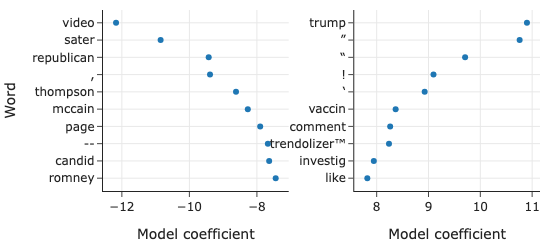

In [24]:
log_reg = model3.named_steps.logisticregressioncv
coefs = (pd.DataFrame(tfidf.vocabulary_.keys(),
                      columns=['word'],
                      index=tfidf.vocabulary_.values())
         .sort_index()
         .assign(coef=log_reg.coef_[0])
         .sort_values('coef')
        )
fig1 = px.scatter(coefs[:10][::-1], x='coef', y='word')
fig2 = px.scatter(coefs[-10:], x='coef', y='word')
fig = left_right(fig1, fig2, horizontal_spacing=0.15)
fig.update_xaxes(title='Model coefficient')
fig.update_yaxes(title='Word', row=1, col=1)

These coefficients show a few quirks about this model. We see that several influential features correspond to punctuation in the original text. It's unclear whether we should clean out the punctuation in the model. On the one hand, punctuation doesn't seem to convey as much meaning as words do. On the other, it seems plausible that, for example, lots of explanation points in an article could help a model decide whether the article is real or fake. In this case, we've decided to keep punctuation, but curious readers can repeat this analysis after stripping the punctuation out to see how the resulting model is affected.

We conclude by displaying the test set error for all three models:

In [25]:
pd.DataFrame({
    'test set error': [model1.score(X_test, y_test),
                       model2.score(X_test, y_test),
                       model3.score(X_test, y_test)]
}, index=['model1', 'model2', 'model3'])

,test set error
model1,0.61
model2,0.70
model3,0.88


As we might expect, the models became more accurate as we introduced more features. The model that used tf-idf performed much better than the models with binary handpicked word features, but it did not meet the 100% accuracy obtained on the train set. This illustrates a common trade-off in modeling: given enough data, more complex models can often outperform simpler ones, especially in situations like this case study where simpler models have too much model bias to perform well. However, complex models can be more difficult to interpret. For example, our tf-idf model had over 20,000 features, which makes it basically impossible to explain how our model makes its decisions. In addition, the tf-idf model takes much longer to make predictions---it's over 100 times slower compared to model 2. All of these factors need to be considered when deciding which model to use in practice.

In addition, we need to be careful about what our models are useful for. In this case, our models use the content of the news articles for prediction, making them highly dependent on the words that appear in the train set. However, our models will likely not perform as well on future news articles that use words that didn't appear in the train set. For example, our models use the US election candidates' names in 2016 for prediction, but they won't know to incorporate the names of the candidates in 2020 or 2024. To use our models in the longer term, we would need to address this issue of *drift*. 

That said, it's surprising that a logistic regression model can perform well with a relatively small amount of feature engineering (tf-idf). We've addressed our original research question: our tf-idf model appears effective for detecting fake news in our dataset, and it could plausibly generalize to other news published in the same time period covered in the training data.